# Model comparison

To demonstrate the use of model comparison criteria, we implement the radon contamination example from the previous lecture. 

Below, we fit a **pooled model**, which assumes a single fixed effect across all counties, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

The data include the observed radon levels and associated covariates for 85 counties in Minnesota.

In [2]:
radon_data = pd.read_csv('../data/radon.csv', index_col=0)
radon_data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


### Pooled model

In [3]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

floor = radon_data.floor.values
log_radon = radon_data.log_radon.values

with Model() as pooled_model:
    
    β = Normal('β', 0, sd=1e5, shape=2)
    σ = HalfCauchy('σ', 5)
    
    θ = β[0] + β[1]*floor
    
    y = Normal('y', θ, sd=σ, observed=log_radon)
    
    trace_p = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:02<00:00, 978.32it/s] 


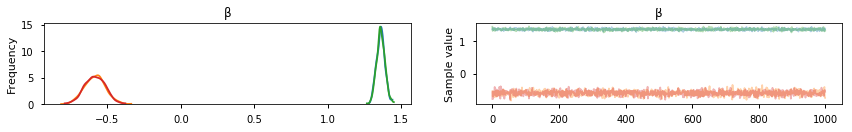

In [4]:
from pymc3 import traceplot

traceplot(trace_p, varnames=['β']);

### Hierarchical model

In [5]:
mn_counties = radon_data.county.unique()
counties = mn_counties.shape[0]
county = radon_data.county_code.values
floor_measure = radon_data.floor.values
                             
with Model() as hierarchical_model:
    
    # Priors
    μ_a = Normal('μ_a', mu=0., tau=0.0001)
    σ_a = HalfCauchy('σ_a', 5)
    
    
    # Random intercepts
    a = Normal('a', mu=μ_a, sd=σ_a, shape=counties)
    # Common slope
    b = Normal('b', mu=0., sd=1e5)
    
    # Model error
    sd_y = HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = a[county] + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=log_radon)
    
    trace_h = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:11<00:00, 174.74it/s]


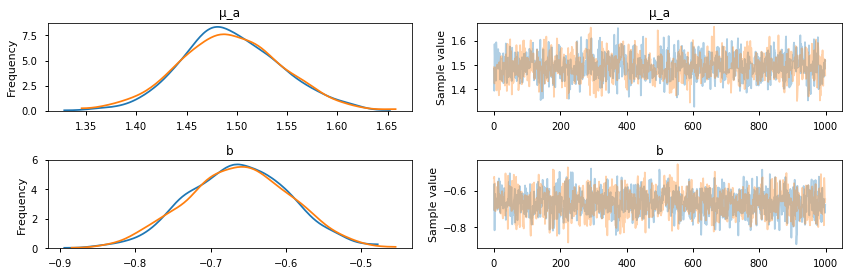

In [6]:
traceplot(trace_h, varnames=['μ_a', 'b']);

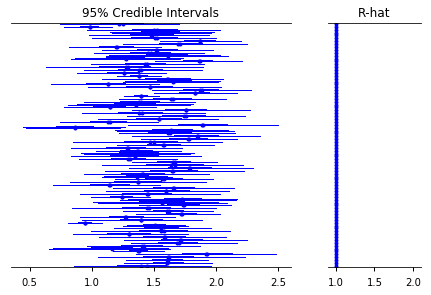

In [7]:
from pymc3 import forestplot

forestplot(trace_h, varnames=['a'], ylabels=['']);

### Deviance Information Criterion (DIC)

DIC (Spiegelhalter et al. 2002) is an information theoretic criterion for estimating predictive accuracy that is analogous to Akaike's Information Criterion (AIC). It is a more Bayesian approach that allows for the modeling of random effects, replacing the maximum likelihood estimate with the posterior mean and using the effective number of parameters to correct for bias.

In [8]:
from pymc3 import dic

pooled_dic = dic(trace_p, pooled_model)

pooled_dic

2233.5248085752382

In [9]:
hierarchical_dic = dic(trace_h, hierarchical_model)
    
hierarchical_dic

2198.2360683683996

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

In [10]:
from pymc3 import waic

pooled_waic = waic(trace_p, pooled_model)
    
pooled_waic.WAIC

2179.7532790289256

In [11]:
hierarchical_waic = waic(trace_h, hierarchical_model)
    
hierarchical_waic.WAIC

/Users/fonnescj/Repos/pymc3/pymc3/stats.py:221: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


2073.2713385785828

PyMC3 includes two convenience functions to help compare WAIC for different models. The first of this functions is `compare`, this one computes WAIC (or LOO) from a set of traces and models and returns a DataFrame.

In [12]:
from pymc3 import compare

df_comp_WAIC = compare((trace_h, trace_p), (hierarchical_model, pooled_model))
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,2073.27,48.82,0,0.93,55.94,0,1
1,2179.75,3.73,106.48,0.07,49.96,21.45,0


We have many columns so let check one by one the meaning of them:


1. The first column contains the values of WAIC. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

2. The second column is the estimated effective number of parameters. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data. 

3. The third column is the relative difference between the value of WAIC for the top-ranked model and the value of WAIC for each model. For this reason we will always get a value of 0 for the first model.

4. Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

5. The fifth column records the standard error for the WAIC computations. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

6. In the same way that we can compute the standard error for each value of WAIC, we can compute the standard error of the differences between two values of WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

7. Finally we have the last column named "warning". A value of 1 indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution. For more details you can read this [paper](https://arxiv.org/abs/1507.04544).

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) of the examples in the book to PyMC3).

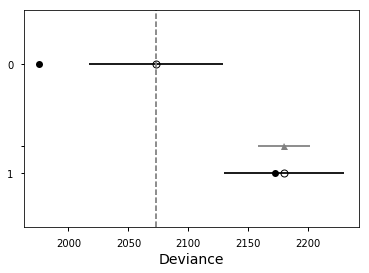

In [13]:
from pymc3 import compareplot

compareplot(df_comp_WAIC);

- The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC. 
- The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.
- The filled black dots are the in-sample deviance of each model, which for WAIC is  2 pWAIC from the corresponding WAIC value.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

In [14]:
from pymc3 import loo

pooled_loo = loo(trace_p, pooled_model)
    
pooled_loo.LOO

/Users/fonnescj/Repos/pymc3/pymc3/stats.py:286: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


2180.5169842435344

In [15]:
hierarchical_loo  = loo(trace_h, hierarchical_model)
    
hierarchical_loo.LOO

/Users/fonnescj/Repos/pymc3/pymc3/stats.py:286: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


2080.6078642915263

We can also use `compare` with LOO.

In [16]:
df_comp_LOO = compare((trace_h, trace_p), (hierarchical_model, pooled_model), ic='LOO')
df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
0,2080.61,52.49,0,0.9,56.78,0,1
1,2180.52,4.11,99.91,0.1,50,22,1


The columns return the equivalent values for LOO, notice that in this example we get two warnings. Also notice that the order of the models is not the same as the one for WAIC.

We can also plot the results

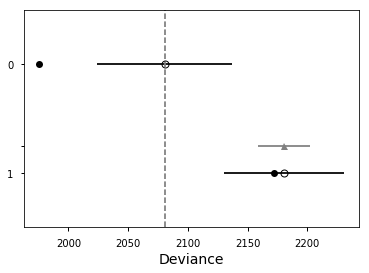

In [17]:
compareplot(df_comp_LOO);

### Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, giving that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of WAIC and LOO.

## Reference

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](http://link.springer.com/article/10.1007/s11222-016-9696-4)